# Importing Libraries

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Working with Spectrograms

In [62]:
data_path = 'data/stock_technical_data/'

In [63]:
df = pd.read_csv(data_path + 'AUBANK.NS.csv', index_col=0)

In [64]:
sample_data = df['Close'].values
print(len(sample_data))

1355


In [65]:
reduced_data = sample_data[:25]

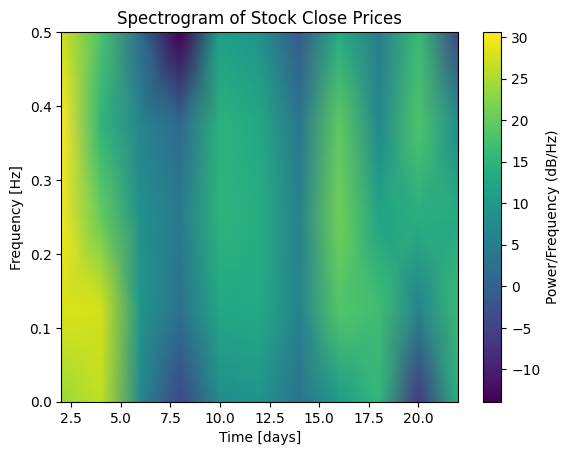

In [66]:
# Compute the spectrogram
frequencies, times, Sxx = spectrogram(reduced_data, fs=1.0, window=('tukey', 0.25), nperseg=4, noverlap=2, nfft=8, detrend='constant', scaling='density', mode='psd')

# Plot the spectrogram
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [days]')
plt.title('Spectrogram of Stock Close Prices')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.show()

# Setting up the Prediction Models

In [67]:
def generate_spectrogram(window_data):
    frequencies, times, Sxx = spectrogram(window_data, fs=1.0, window=('tukey', 0.25), nperseg=4, noverlap=2, nfft=8, detrend='constant', scaling='density', mode='psd')
    return frequencies, times, Sxx

1000


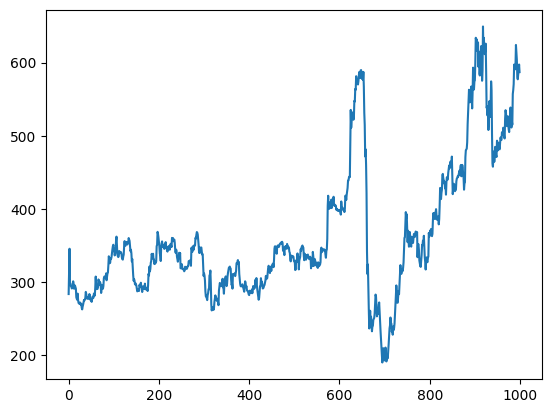

In [68]:
noofdays = 25

close_prices = df['Close'].values
close_prices = close_prices[0:1000]
print(len(close_prices))

# plot the close prices
plt.plot(close_prices)

In [69]:
X = []
y = []

for i in range(len(close_prices) - noofdays):
    window_data = close_prices[i:i + noofdays]
    spectrogram_data = generate_spectrogram(window_data)
    X.append(spectrogram_data[2])
    # Label: 1 if price on day 26 is greater than day 25, else 0
    label = 1 if close_prices[i + noofdays] > close_prices[i + noofdays - 1] else 0
    y.append(label)

In [70]:
print(len(X))
print(len(y))

975
975


In [71]:
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(975, 5, 11)
(975,)


In [72]:
# Reshape X to add a channel dimension (batch_size, 1, 5, 11)
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

# Convert X and y to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [73]:
# Create a DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [74]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self._to_linear = None
        self._get_conv_output_size()

        self.fc1 = nn.Linear(self._to_linear, 64)
        self.fc2 = nn.Linear(64, 2) 

    def _get_conv_output_size(self):

        x = torch.randn(1, 1, 5, 11)  
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        self._to_linear = x.numel()  

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  
        x = self.pool(self.relu(self.conv2(x)))  
        x = x.view(-1, self._to_linear)  
        x = self.relu(self.fc1(x)) 
        x = self.dropout(x)
        x = self.fc2(x) 
        return x


In [75]:
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    print("Accuracy: ", (outputs.argmax(1) == labels).sum().item() / len(labels))

print("Training complete.")

Epoch [1/20], Loss: 6.2915
Accuracy:  0.4666666666666667
Epoch [2/20], Loss: 1.5491
Accuracy:  0.4666666666666667
Epoch [3/20], Loss: 7.8655
Accuracy:  0.5333333333333333
Epoch [4/20], Loss: 0.6127
Accuracy:  0.4666666666666667
Epoch [5/20], Loss: 0.6059
Accuracy:  0.6666666666666666
Epoch [6/20], Loss: 0.7193
Accuracy:  0.26666666666666666
Epoch [7/20], Loss: 0.7060
Accuracy:  0.4
Epoch [8/20], Loss: 0.6804
Accuracy:  0.5333333333333333
Epoch [9/20], Loss: 0.6785
Accuracy:  0.8
Epoch [10/20], Loss: 0.6896
Accuracy:  0.6
Epoch [11/20], Loss: 0.6949
Accuracy:  0.4666666666666667
Epoch [12/20], Loss: 0.6977
Accuracy:  0.4666666666666667
Epoch [13/20], Loss: 0.6909
Accuracy:  0.5333333333333333
Epoch [14/20], Loss: 0.7247
Accuracy:  0.3333333333333333
Epoch [15/20], Loss: 0.7117
Accuracy:  0.4
Epoch [16/20], Loss: 0.7048
Accuracy:  0.4
Epoch [17/20], Loss: 0.6941
Accuracy:  0.4666666666666667
Epoch [18/20], Loss: 0.6919
Accuracy:  0.5333333333333333
Epoch [19/20], Loss: 0.6849
Accuracy:  